<center><h2> Customer Purchase Dynamics for Ecommerce Orders and Payments </h2></center>

<h4>Analysing various data sources of Ecommerce Purchases, Orders, Payments and Reviews to understand the trending factors leading to Purchase Dynamics in this industry. </h4>

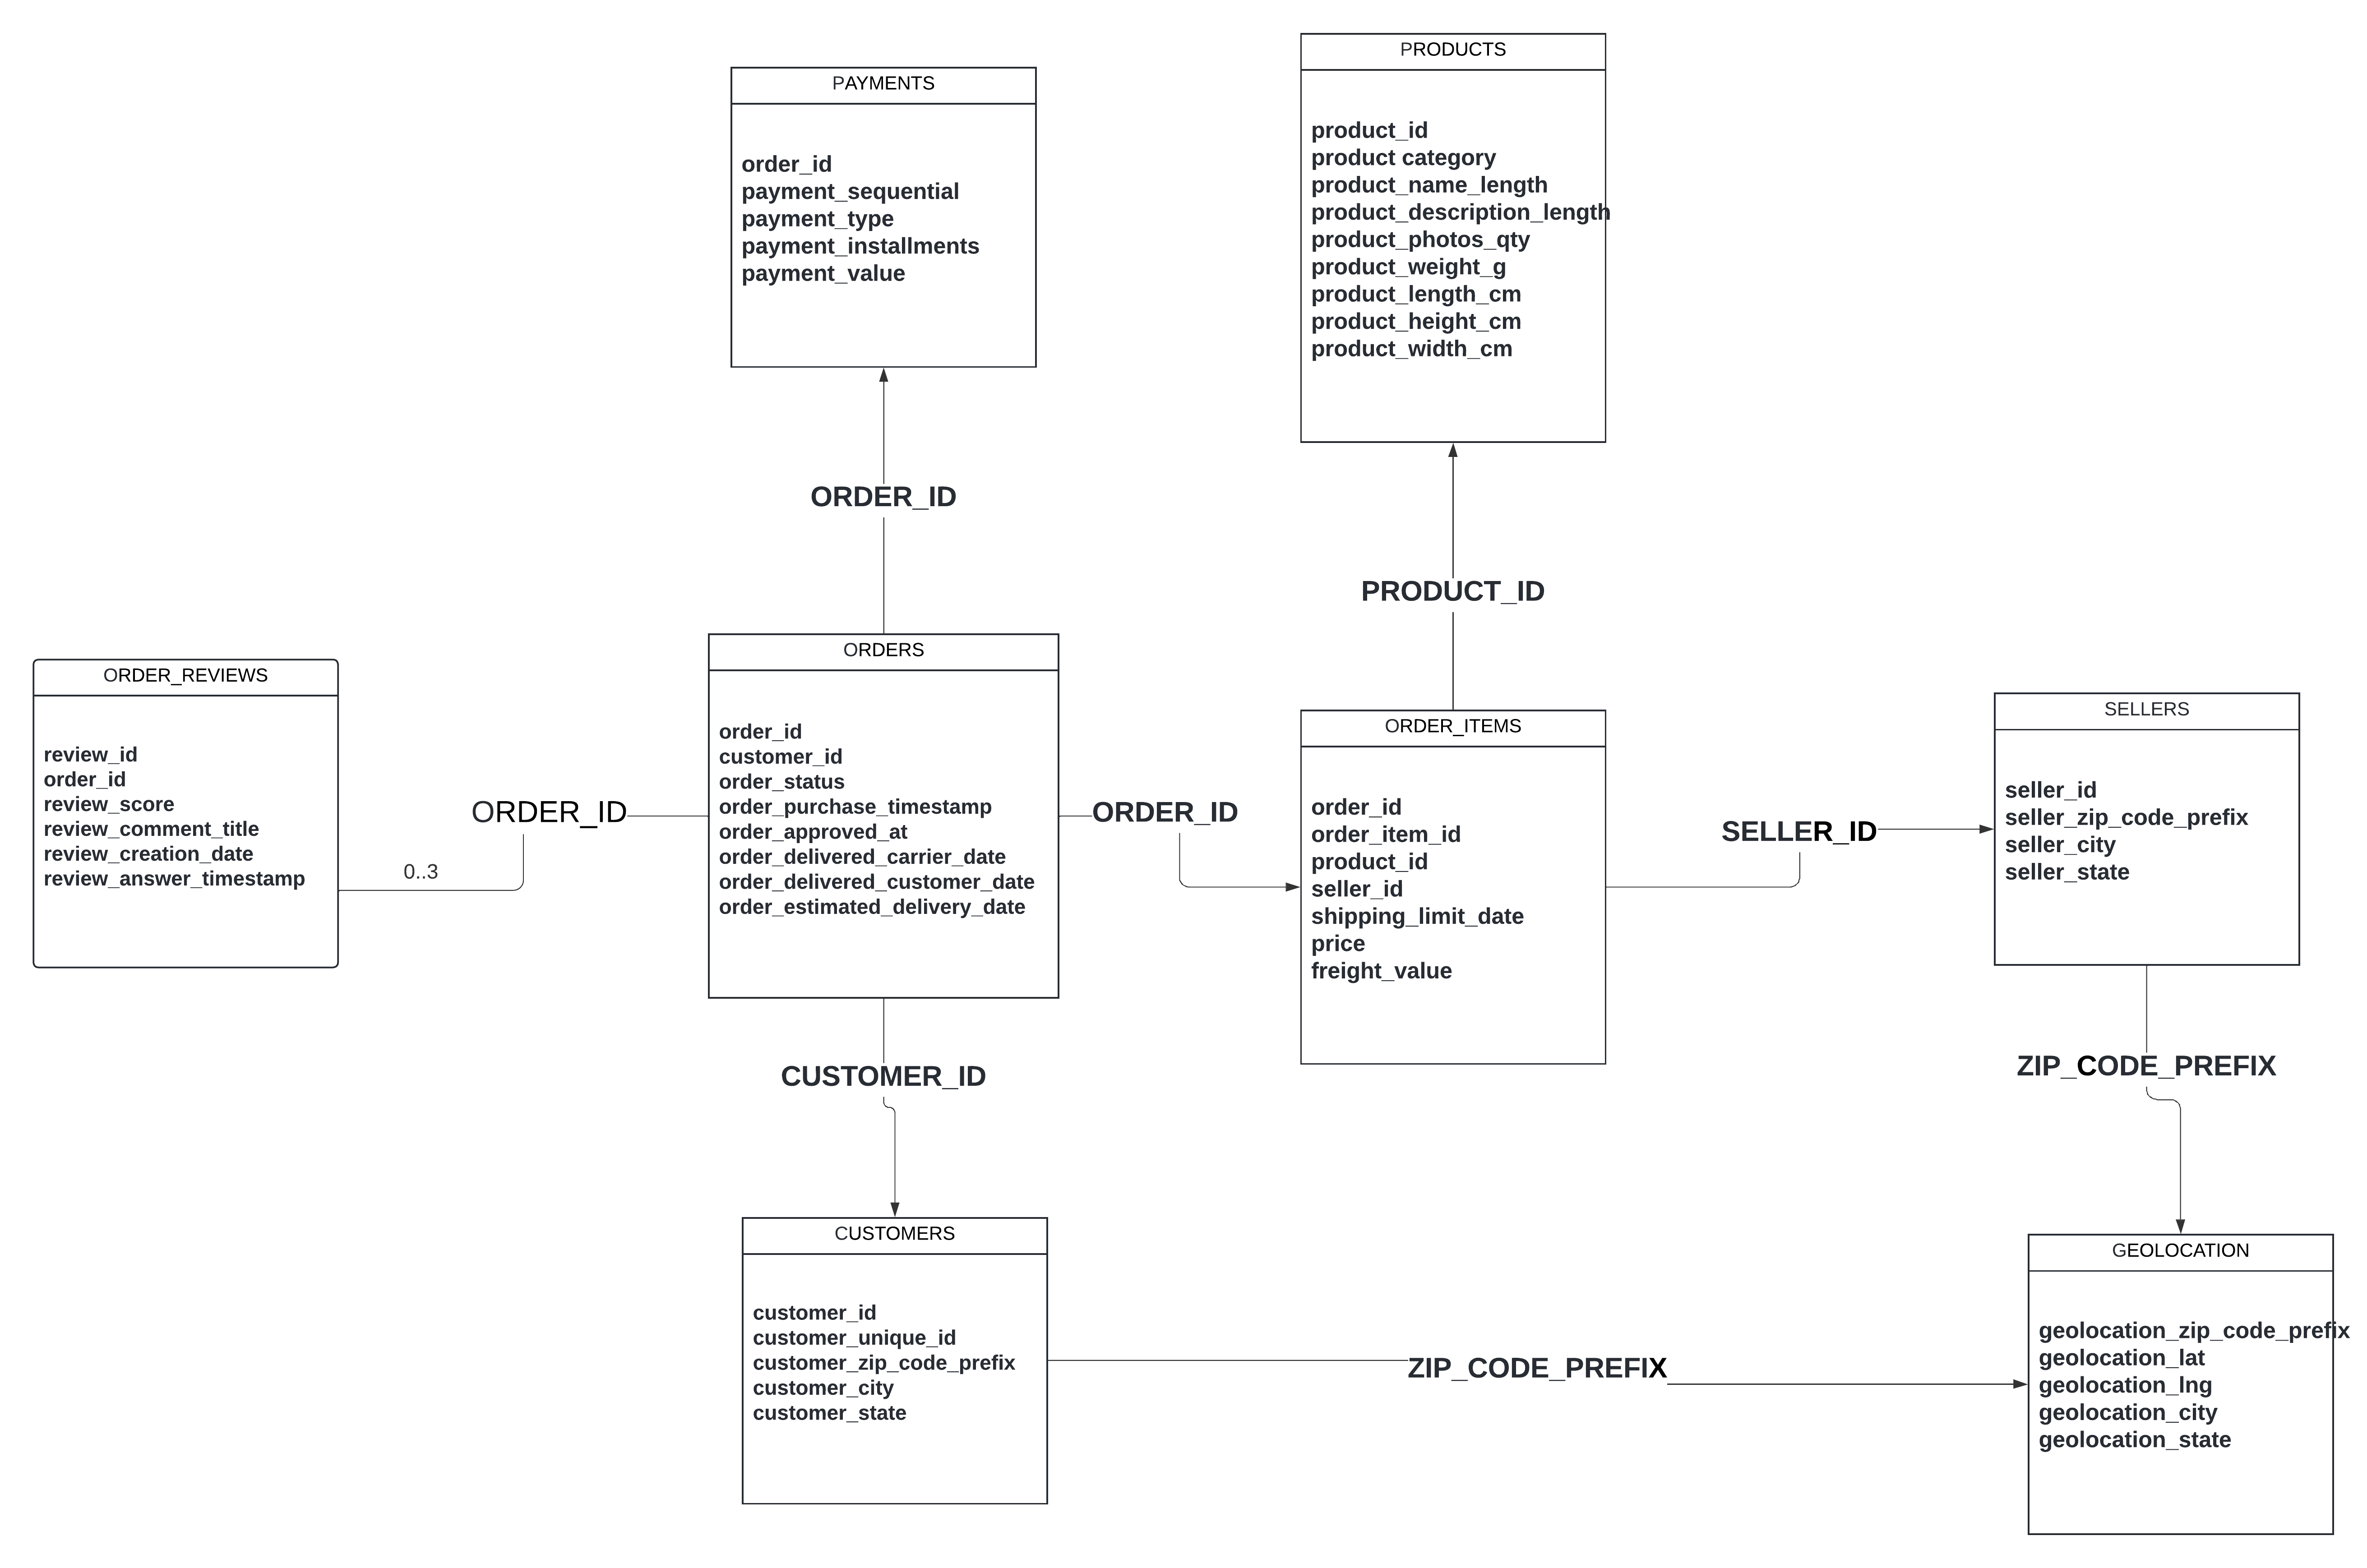

In [5]:
#### ER Diagram
from IPython.display import Image
Image("ER Diagram 1.png")

In [6]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import sqlite3


In [7]:
path = 'C:/Users/ArshiaAchar/Desktop/DS_Projects/CustomerPurchaseDynamics/data'         # folder path
files = os.listdir(path)                        # contains all the datasets in the specified location
dfs = dict()

# iterates over all files in the folder
for item in files:
    df_name = item.split('.')[0]                # splits on . and takes the first part. The name of file
    file_path = os.path.join(path, item)
    data = pd.read_csv(file_path,encoding='latin1')
    dfs[df_name] = data             # created a dictionary of all dataframes

conn = sqlite3.connect('db_sumeru.db')           # connect to the databased
for name, df in dfs.items():                     # adding dataframes to the database
  df.to_sql(name, conn, if_exists='replace', index=False)




#### 1.1 Data type of all columns in Customers

In [8]:
# Describing the columns and the datatypes for the table Customers
query = pd.read_sql_query('PRAGMA table_info(customers)',conn)
print(query)

   cid                      name     type  notnull dflt_value  pk
0    0               customer_id     TEXT        0       None   0
1    1        customer_unique_id     TEXT        0       None   0
2    2  customer_zip_code_prefix  INTEGER        0       None   0
3    3             customer_city     TEXT        0       None   0
4    4            customer_state     TEXT        0       None   0


1. There are 5 columns in customers table
2. 4 of the are categorical or object. 1 column in numerical
3. No missing data

#### 1.2 Time range of orders

In [9]:
# getting the oldest and the newest date of orders that were purchased
query = "select min(order_purchase_timestamp),max(order_purchase_timestamp) from orders"
pd.read_sql_query(query,conn)

,min(order_purchase_timestamp),max(order_purchase_timestamp)
0,2016-09-04 21:15:19,2018-10-17 17:30:18


Orders were placed between 4th Sep 2016 to 17th Oct 2018

#### 1.3 Unique cities and states of customers ordered

In [10]:
# FOr all customers in the above time range, get the unique locations. That is cities and states
query = """select count(DISTINCT cus.customer_city) as Unique_Cities
,count(DISTINCT cus.customer_state) as Unique_Stats
from orders ord 
inner join 
customers cus 
on ord.customer_id = cus.customer_id

where
ord.order_purchase_timestamp >= (select min(order_purchase_timestamp) from orders)
AND
ord.order_purchase_timestamp <= (select max(order_purchase_timestamp) from orders)

"""
pd.read_sql_query(query,conn)

,Unique_Cities,Unique_Stats
0,4119,27


The customers that have ordered in the time range given above are from 4119 unique cities and 27 States.

#### 2.1 Trend in the number of orders in past years

In [11]:
# To get the trend in orders. Group by the year and the number of orders in that year
query = """
SELECT strftime('%Y',order_purchase_timestamp) AS OrderYear,
COUNT(order_id) RecordCount
FROM orders
GROUP BY OrderYear
ORDER BY OrderYear
"""

data = pd.read_sql_query(query,conn)
data

,OrderYear,RecordCount
0,2016,329
1,2017,45101
2,2018,54011


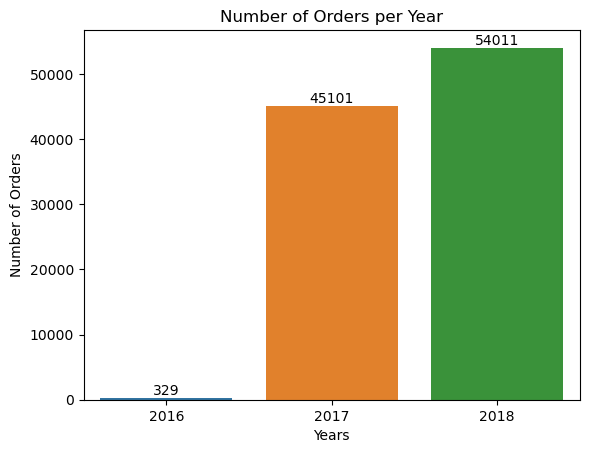

In [12]:
ax = sns.barplot(data=data,x='OrderYear',y='RecordCount')
plt.title('Number of Orders per Year')

plt.xlabel('Years')
plt.ylabel('Number of Orders')
for label in ax.containers:
    plt.bar_label(label)
plt.show()

The number of orders from 2016 has been increasing in this eccommerce site. SO, there is an increasing trend in customer orders. 2017 and 2018 have seen large number of orders as compared to 2016. There could have been a change in the advertising of the site leading to such huge sales. Or This ecommerce site was launched in 2016 and it was not well known by the puplic

#### 2.2 Monthly trend in number of orders

In [13]:
# Similarly, the trend was queried for each month in the above 3 years
query = """
SELECT strftime('%m',order_purchase_timestamp) AS OrderMonth,
COUNT(order_id) count
FROM orders
GROUP BY OrderMonth
ORDER BY OrderMonth
"""

data = pd.read_sql_query(query,conn)
data

,OrderMonth,count
0,01,8069
1,02,8508
2,03,9893
3,04,9343
4,05,10573
5,06,9412
6,07,10318
7,08,10843
8,09,4305
9,10,4959


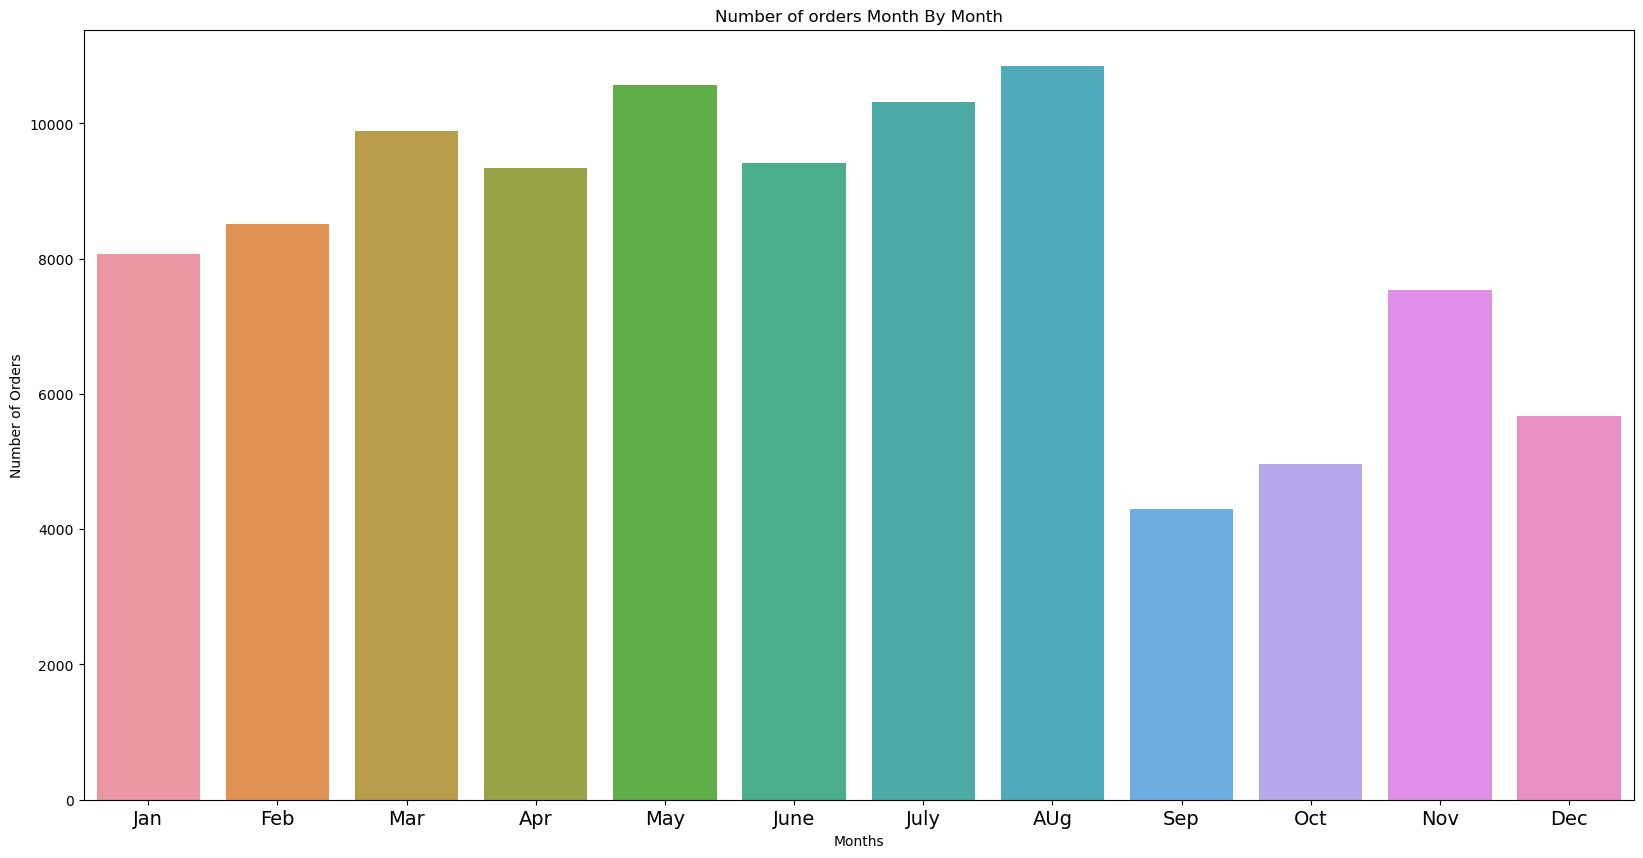

In [14]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=data,x='OrderMonth',y='count')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','June','July','AUg','Sep','Oct','Nov','Dec'],fontsize=14)
plt.title('Number of orders Month By Month')
plt.xlabel('Months')
plt.ylabel('Number of Orders')
plt.show()

1. The number of orders purchased are high during the summers and lower towards the end of the year.

2. There is a trend seen in the number of orders. Every 4 months, have similar number of customer orders.

3. There is a seasonality present in the data. The first 8 months of the year, the weather in Brazil is a bit extreme. People tend to stay at home longer leading to more eccommerce sales. The last few months, Brazil has pleasant weather, with high tourists visiting. This leads to low sales

#### 2.3 Trend in the number of orders based on the time of purchase

In [15]:
query = """
SELECT
CASE
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=0 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=06  THEN 'Dawn'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=07 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=12  THEN 'Morning'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=13 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=18  THEN 'Afternoon'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=19 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=23  THEN 'Night'
END AS PurchaseHour,
COUNT( * ) order_count
from orders
group by (
CASE
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=0 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=06  THEN 'Dawn'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=07 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=12  THEN 'Morning'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=13 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=18  THEN 'Afternoon'
    WHEN CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)>=19 AND CAST(strftime('%H',order_purchase_timestamp) AS INTEGER)<=23  THEN 'Night'
END
)
"""

data = pd.read_sql_query(query,conn)
data

,PurchaseHour,order_count
0,Afternoon,38135
1,Dawn,5242
2,Morning,27733
3,Night,28331


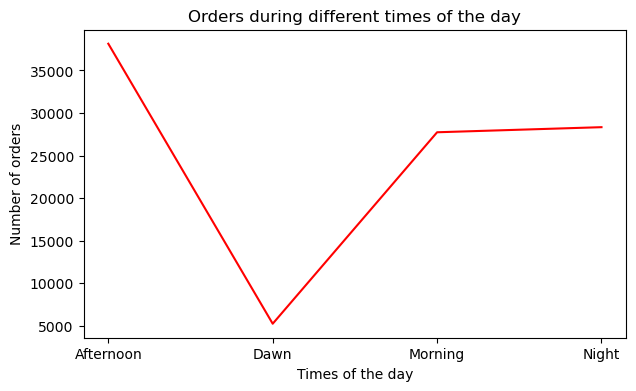

In [16]:
plt.figure(figsize=(7,4))
ax = sns.lineplot(data=data,x='PurchaseHour',y='order_count',color='red')
plt.title('Orders during different times of the day')
plt.xlabel('Times of the day')
plt.ylabel('Number of orders')
plt.show()

All the customer state data given in the dataset is for Brazilian states. 

We can see that most customers in Brazil purchase orders in the afternoon. There are a lot of customers that shop on ecommerce sites mid morning and late night. 

People don't prefer to shop in the early hours of the day.

This captures the traffic flow for order purchases for the Brazilian ecommerce market

#### 3.1 Month on Month Orders for each state

In [17]:
query = """
SELECT 
cus.customer_state,
strftime('%m',o.order_purchase_timestamp) purchase_month,
count(*) order_count
FROM 
orders o inner join customers cus
on o.customer_id == cus.customer_id
GROUP BY cus.customer_state, purchase_month
order BY cus.customer_state, purchase_month
"""

state_month_order_count = pd.read_sql_query(query,conn)
state_month_order_count

,customer_state,purchase_month,order_count
0,AC,01,8
1,AC,02,6
2,AC,03,4
3,AC,04,9
4,AC,05,10
...,...,...,...
317,TO,08,28
318,TO,09,17
319,TO,10,13
320,TO,11,17


In [18]:
# Let's look at the analysis for a particular state
state_month_order_count[state_month_order_count.customer_state == 'AC']

,customer_state,purchase_month,order_count
0,AC,01,8
1,AC,02,6
2,AC,03,4
3,AC,04,9
4,AC,05,10
5,AC,06,7
6,AC,07,9
7,AC,08,7
8,AC,09,5
9,AC,10,6


In [19]:
len(state_month_order_count.customer_state.unique())              # there are 27 states in our dataset

27

The state AC has most orders in the month of May and the least in March. Sales in the winter is the least

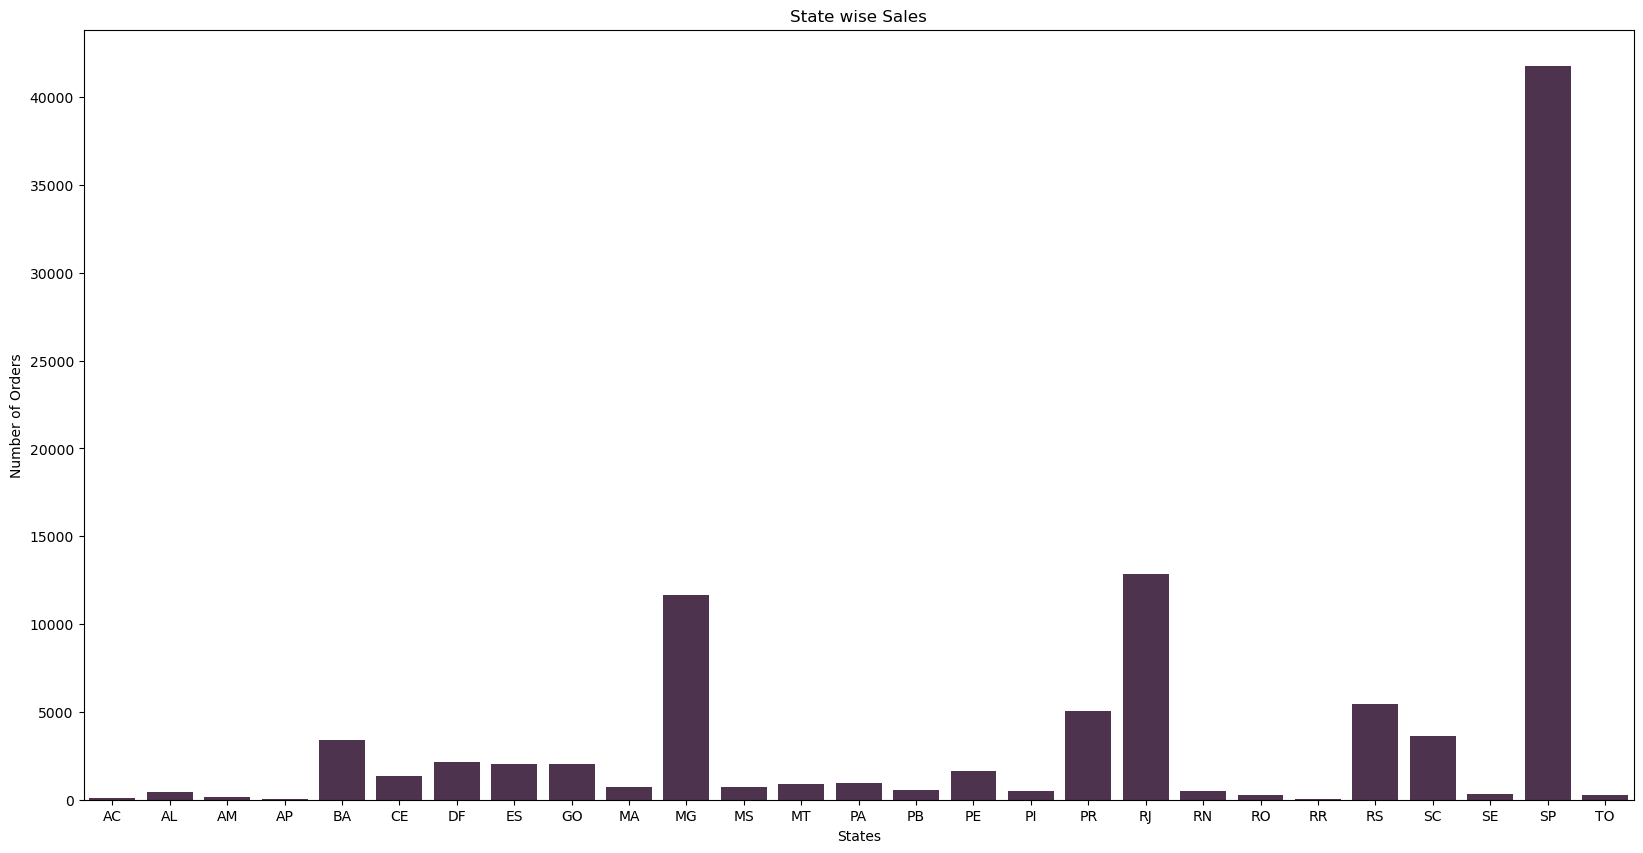

In [20]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=state_month_order_count,x='customer_state',y='order_count',errorbar=None,estimator='sum',color='purple',saturation=0.2)
plt.title('State wise Sales')
plt.xlabel('States')
plt.ylabel('Number of Orders')
plt.show()

1. State SP has the highest number of orders

2. Top states having the highest number of orders are SP, MG and RJ. These state have over 10000 orders in a year

3. There are states having very low number of orders

4. The variance in the number of orders from each state is very high. This could tell us that the presence of this ecommerce site is not uniformly distributed

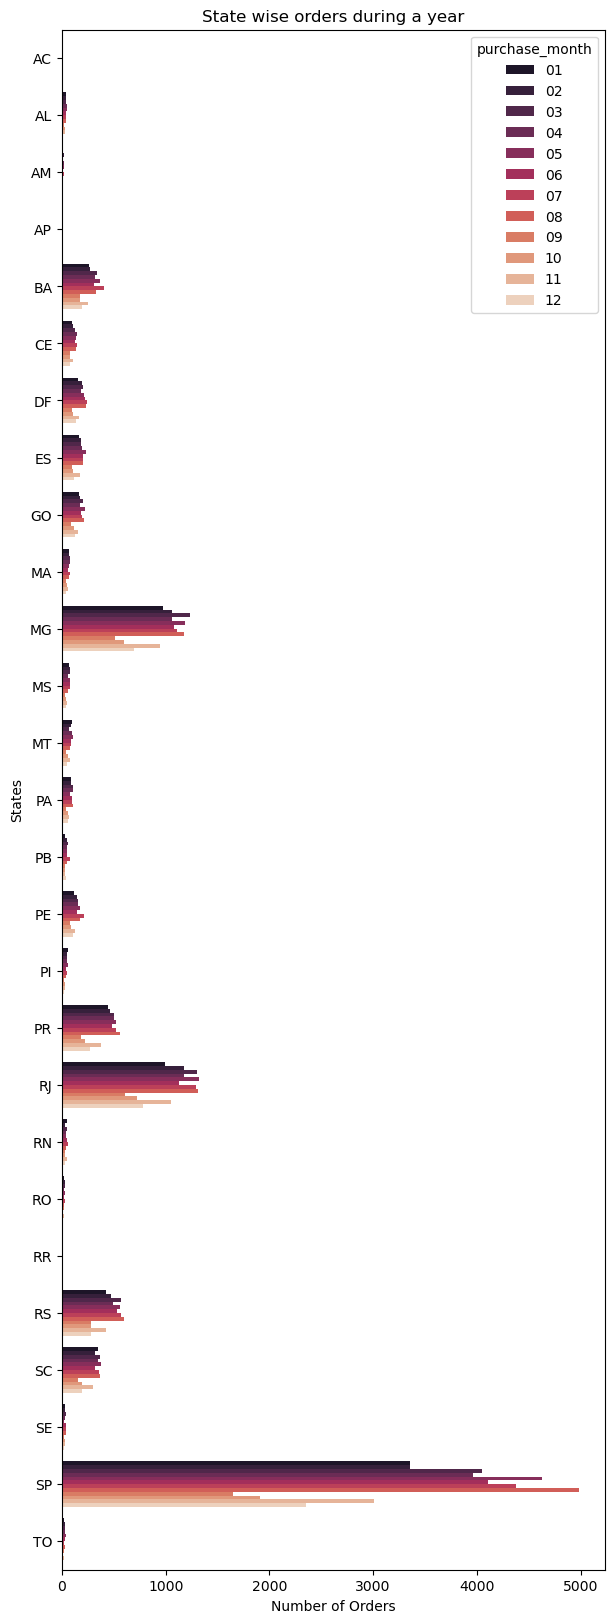

In [21]:
plt.figure(figsize=(7,20))
ax = sns.barplot(data=state_month_order_count,y='customer_state',x='order_count',hue='purchase_month',errorbar=None,estimator='sum',palette='rocket',saturation=0.7)
plt.xlabel('Number of Orders')
plt.ylabel('States')
plt.title('State wise orders during a year')
plt.show()

The state having high sales, we can see a pattern through the years. The inital part of the year has uniform sales and then there is dip around august after which the sales once again pick up. This rise could be because towards the end of the year there are more festivals causing people to shop from ecommerce sites more.

Regardless of the state, this annual trend is the same.

#### 3.2 Customer distribution across State

In [22]:
query = """
SELECT
customer_state State,
count(DISTINCT customer_id) Number_customers
FROM
customers
GROUP BY customer_state
ORDER BY Number_customers
"""
data = pd.read_sql_query(query,conn)
data

,State,Number_customers
0,RR,46
1,AP,68
2,AC,81
3,AM,148
4,RO,253
5,TO,280
6,SE,350
7,AL,413
8,RN,485
9,PI,495


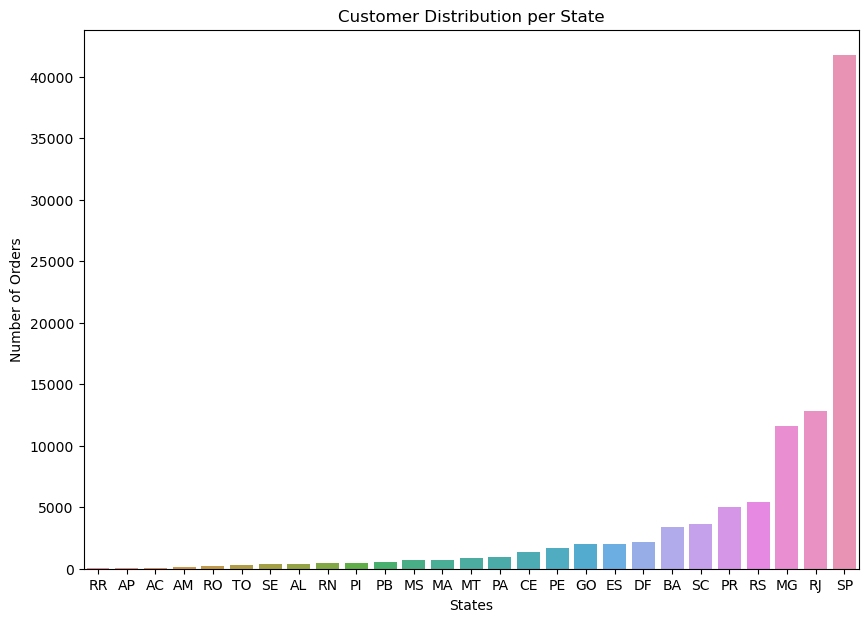

In [23]:
plt.figure(figsize=(10,7))
ax = sns.barplot(data=data,x='State',y='Number_customers',errorbar=None)
plt.title('Customer Distribution per State')
plt.xlabel('States')
plt.ylabel('Number of Orders')
plt.show()

1. Customer distribution is the highest in SP, RJ and MG. As these states have the highest number of orders, the number of distinct customers from these state would be the highest. 

2. This analysis shows us the states preferring this ecommerce site and the states that are preferring some other competitor

#### 4.1 Percentage Increase in order cost from 2017 to 2018 for Jan-Aug

In [24]:
query = """
SELECT
cast(strftime('%Y',o.order_purchase_timestamp) AS INTEGER) OrderYear,
cast(strftime('%m',o.order_purchase_timestamp) AS INTEGER) OrderMonth,
sum(p.payment_value) OrderCost
FROM orders o INNER JOIN payments p
ON o.order_id = p.order_id
WHERE (OrderYear = 2017 OR OrderYear = 2018) AND (OrderMonth BETWEEN 1 AND 8)
GROUP BY OrderYear
ORDER BY OrderYear DESC
;

"""

data = pd.read_sql_query(query,conn)
data

,OrderYear,OrderMonth,OrderCost
0,2018,7,8694733.84
1,2017,7,3669022.12


The total Cost of Orders in 2018 and 2017 for the months Jan to Aug is given above.

In [25]:
# (8694733.84-3669022.12)*100/3669022.12

In [26]:
query = """

WITH Year_Costs AS
(
        SELECT
        cast(strftime('%Y',o.order_purchase_timestamp) AS INTEGER) OrderYear,
        cast(strftime('%m',o.order_purchase_timestamp) AS INTEGER) OrderMonth,
        sum(p.payment_value) OrderCost
        FROM orders o INNER JOIN payments p
        ON o.order_id = p.order_id
        WHERE (OrderYear = 2017 OR OrderYear = 2018) AND (OrderMonth BETWEEN 1 AND 8)
        GROUP BY OrderYear
        ORDER BY OrderYear DESC
)
SELECT
((
        SELECT
        OrderCost
        FROM Year_Costs   
        where OrderYear == 2018
) / 
(
        SELECT
        OrderCost
        FROM Year_Costs
        where OrderYear == 2017
) 
- 1)*100 Percent_increase

FROM 
Year_Costs 
LIMIT 1
;

"""

data = pd.read_sql_query(query,conn)
data

,Percent_increase
0,136.976872


There is a 137% increase in the cost of orders ordered by customers in 2018 over 2017. This value is only for the first 8 months of the year. As we have seen the number of orders for 2017 and 2018 are quite high. So, if there is so much difference in the cost of orders this would mean than customers prefer to buy more expensive items in 2018 than in 2017.

#### 4.2 Total, Average value of orders for each state

In [27]:
query="""
SELECT
cus.customer_state AS 'Customer State',
sum(oi.price) AS 'Total Payment',
avg(oi.price) AS 'Average Payment'
FROM
orders o INNER JOIN order_items oi 
ON oi.order_id = o.order_id
INNER JOIN
customers cus
ON o.customer_id = cus.customer_id
GROUP BY cus.customer_state
ORDER BY sum(oi.price) DESC
"""

data = pd.read_sql_query(query,conn)
data

,Customer State,Total Payment,Average Payment
0,SP,5.202955e+06,109.653629
1,RJ,1.824093e+06,125.117818
2,MG,1.585308e+06,120.748574
3,RS,7.503040e+05,120.337453
4,PR,6.830838e+05,119.004139
5,SC,5.205533e+05,124.653578
6,BA,5.113500e+05,134.601208
7,DF,3.026039e+05,125.770549
8,GO,2.945919e+05,126.271732
9,ES,2.750373e+05,121.913701


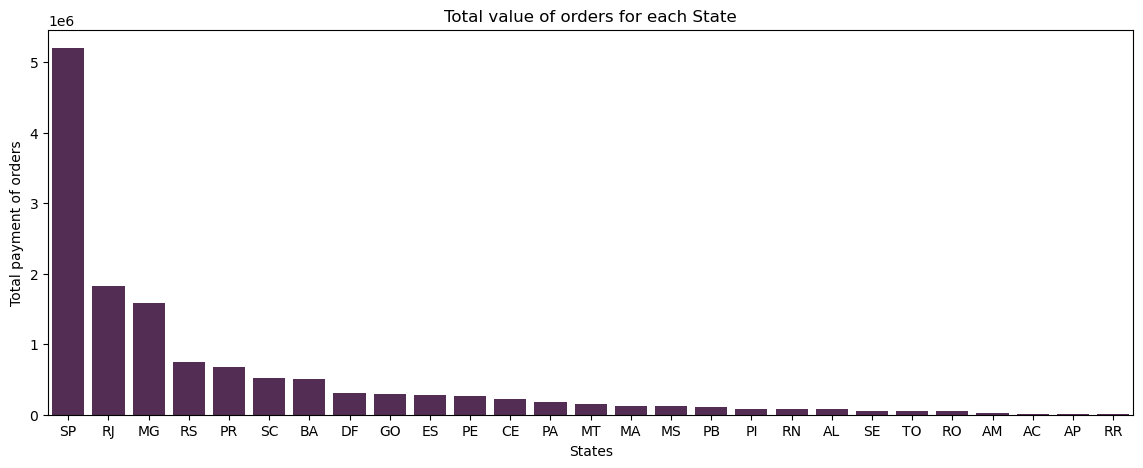

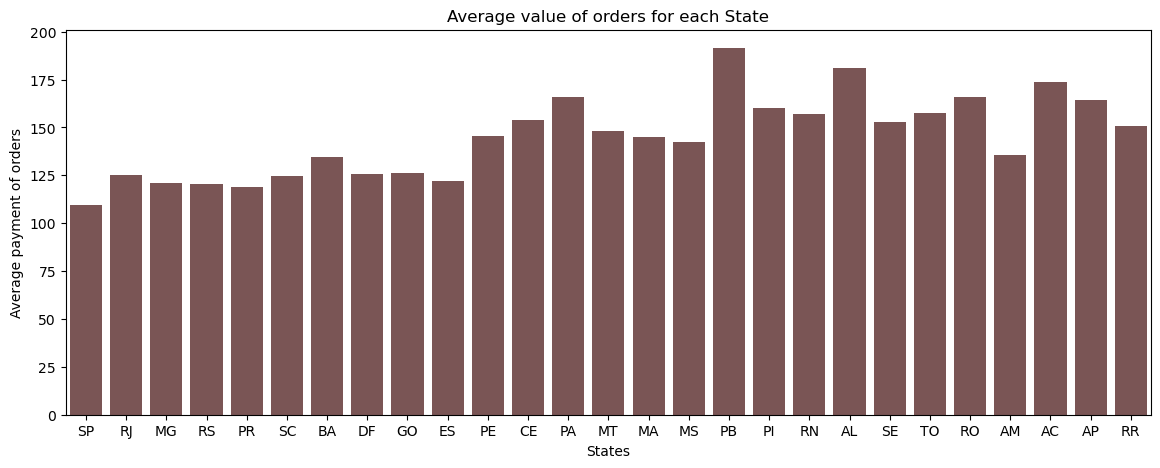

In [28]:
plt.figure(figsize=(14,5))
ax = sns.barplot(data=data,x='Customer State',y='Total Payment',errorbar=None,color='purple',saturation=0.3)
plt.title('Total value of orders for each State')
plt.xlabel('States')
plt.ylabel('Total payment of orders')
plt.show()

plt.figure(figsize=(14,5))
ax = sns.barplot(data=data,x='Customer State',y='Average Payment',errorbar=None,color='brown',saturation=0.3)
plt.title('Average value of orders for each State')
plt.xlabel('States')
plt.ylabel('Average payment of orders')
plt.show()

1. The states with the highest number of orders and largest customer base are the ones that also have the highest total price of orders

2. There is a huge gap in sales between different states in Brazil

3. The average price of orders in each state is more or less the same. This means that in every state, customers spend a similar amount on every order. The states having the highest number of orders have a large total price but the average still remains the same

4. Items ordered on this eccomerce site have similar prices.

5. Customers might have similar spending habits accross states

#### 4.3 Total and Average freight value of orders for each state

In [29]:
query="""
SELECT
cus.customer_state AS 'Customer State',
sum(oi.freight_value) AS 'Total Payment',
avg(oi.freight_value) AS 'Average Payment'
FROM
orders o INNER JOIN order_items oi 
ON oi.order_id = o.order_id
INNER JOIN
customers cus
ON o.customer_id = cus.customer_id
GROUP BY cus.customer_state
ORDER BY sum(oi.freight_value) DESC
"""

data = pd.read_sql_query(query,conn)
data

,Customer State,Total Payment,Average Payment
0,SP,718723.07,15.147275
1,RJ,305589.31,20.960924
2,MG,270853.46,20.630167
3,RS,135522.74,21.735804
4,PR,117851.68,20.531652
5,BA,100156.68,26.363959
6,SC,89660.26,21.470369
7,PE,59449.66,32.917863
8,GO,53114.98,22.766815
9,DF,50625.50,21.041355


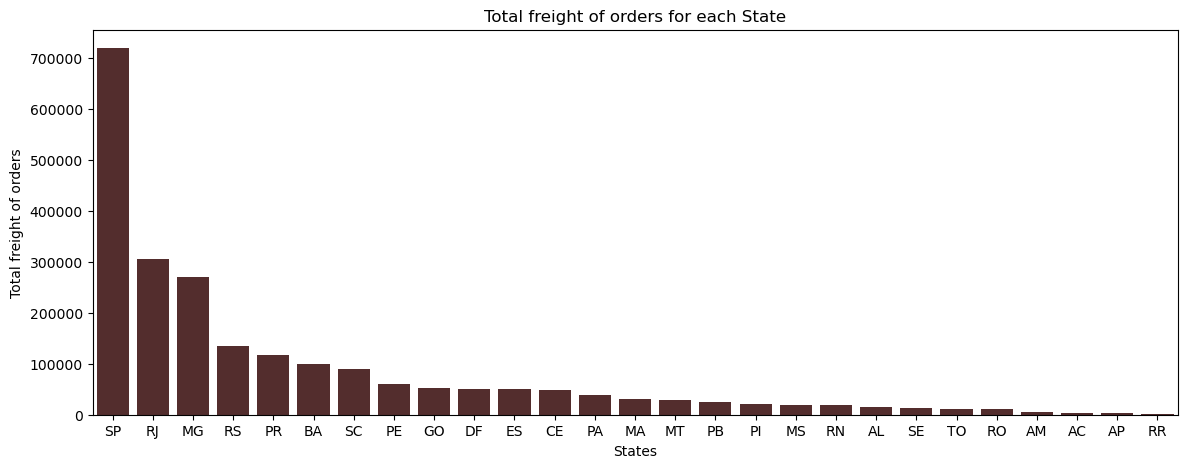

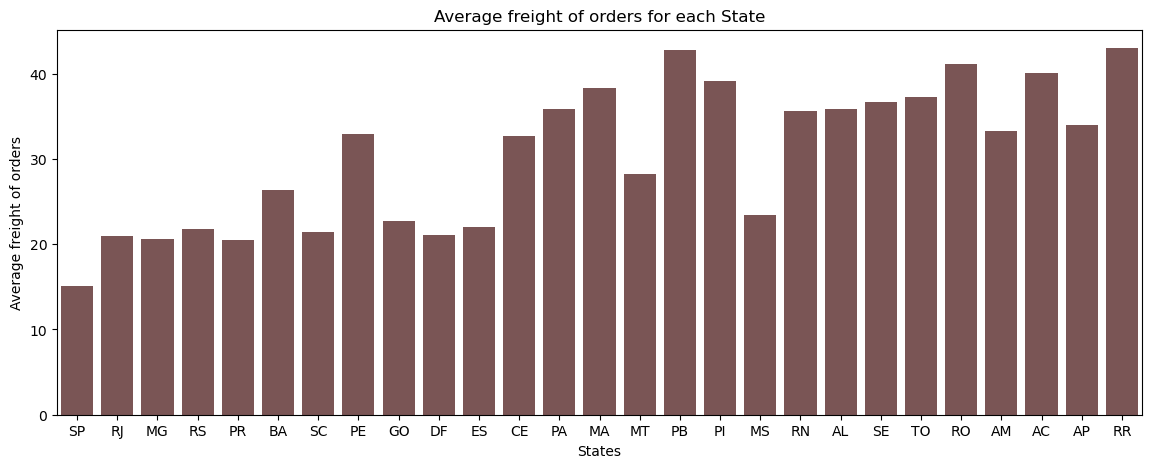

In [30]:
plt.figure(figsize=(14,5))
ax = sns.barplot(data=data,x='Customer State',y='Total Payment',errorbar=None,color='maroon',saturation=0.3)
plt.title('Total freight of orders for each State')
plt.xlabel('States')
plt.ylabel('Total freight of orders')
plt.show()

plt.figure(figsize=(14,5))
ax = sns.barplot(data=data,x='Customer State',y='Average Payment',errorbar=None,color='brown',saturation=0.3)
plt.title('Average freight of orders for each State')
plt.xlabel('States')
plt.ylabel('Average freight of orders')
plt.show()

1. The trend seen in the states is similar in total freight price for each state and the order price in each state.

2. There are few states that have a larger total freight value compared to other, this would be because these states have more number of orders

3. The average freight of each order is very high for the state PB and the lowest for SP. This means logistic fees for sales expense is not uniform for all states. 

4. States having the highest number of orders like SP, RJ and MG have very low freight price. This could be a reason for the large number of orders in these states.

5. States having a higher logistic fees have low number of orders. Customers in these states would prefer other sites having lower freight value.

#### 5.1 Delivery time and Estimated Delivery time of orders

In [31]:
query = """
SELECT
order_delivered_customer_date,
order_purchase_timestamp,
order_estimated_delivery_date,
ROUND(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) DeliveryTime,
ROUND(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_estimated_delivery_date)) EstimatedDelivery 
FROM orders
"""
data = pd.read_sql_query(query,conn)

data

,order_delivered_customer_date,order_purchase_timestamp,order_estimated_delivery_date,DeliveryTime,EstimatedDelivery
0,2017-10-10 21:25:13,2017-10-02 10:56:33,2017-10-18 00:00:00,8.0,-7.0
1,2018-08-07 15:27:45,2018-07-24 20:41:37,2018-08-13 00:00:00,14.0,-5.0
2,2018-08-17 18:06:29,2018-08-08 08:38:49,2018-09-04 00:00:00,9.0,-17.0
3,2017-12-02 00:28:42,2017-11-18 19:28:06,2017-12-15 00:00:00,13.0,-13.0
4,2018-02-16 18:17:02,2018-02-13 21:18:39,2018-02-26 00:00:00,3.0,-9.0
...,...,...,...,...,...
99436,2017-03-17 15:08:01,2017-03-09 09:54:05,2017-03-28 00:00:00,8.0,-10.0
99437,2018-02-28 17:37:56,2018-02-06 12:58:58,2018-03-02 00:00:00,22.0,-1.0
99438,2017-09-21 11:24:17,2017-08-27 14:46:43,2017-09-27 00:00:00,25.0,-6.0
99439,2018-01-25 23:32:54,2018-01-08 21:28:27,2018-02-15 00:00:00,17.0,-20.0


DeliveryTime is the number of days it took for the order to be delivered to the customer since the purchase.
EstimatedDelivery tells us how early or late was the order delivered as compared to the date provided to the customers. The negative values tells us the orders were early while the positive values tell us the late orders

In [32]:
print('Total Number of Orders: ',data.shape[0])
print('Number of orders that were delivered late:',data[data.EstimatedDelivery > 0 ].shape[0])
print('Number of orders that were delivered early:',data[data.EstimatedDelivery < 0 ].shape[0])
print('Number of orders that were delivered on time:',data[data.EstimatedDelivery == 0 ].shape[0])

# there are 2965 missing data points

Total Number of Orders:  99441
Number of orders that were delivered late: 7646
Number of orders that were delivered early: 87370
Number of orders that were delivered on time: 1460


In [33]:
# 7646+87370+1460+2965

In [34]:
data

,order_delivered_customer_date,order_purchase_timestamp,order_estimated_delivery_date,DeliveryTime,EstimatedDelivery
0,2017-10-10 21:25:13,2017-10-02 10:56:33,2017-10-18 00:00:00,8.0,-7.0
1,2018-08-07 15:27:45,2018-07-24 20:41:37,2018-08-13 00:00:00,14.0,-5.0
2,2018-08-17 18:06:29,2018-08-08 08:38:49,2018-09-04 00:00:00,9.0,-17.0
3,2017-12-02 00:28:42,2017-11-18 19:28:06,2017-12-15 00:00:00,13.0,-13.0
4,2018-02-16 18:17:02,2018-02-13 21:18:39,2018-02-26 00:00:00,3.0,-9.0
...,...,...,...,...,...
99436,2017-03-17 15:08:01,2017-03-09 09:54:05,2017-03-28 00:00:00,8.0,-10.0
99437,2018-02-28 17:37:56,2018-02-06 12:58:58,2018-03-02 00:00:00,22.0,-1.0
99438,2017-09-21 11:24:17,2017-08-27 14:46:43,2017-09-27 00:00:00,25.0,-6.0
99439,2018-01-25 23:32:54,2018-01-08 21:28:27,2018-02-15 00:00:00,17.0,-20.0


In [35]:
status = []


# categorizing each order as Late, Early or On Time with respect to estimated and actual devivery times
for value in data.EstimatedDelivery:
    if value > 0:
        status.append('late')
    elif value < 0:
        status.append('early')
    elif value == 0:
        status.append('OnTime')
    else:
        status.append(np.nan)

data['Order_Status'] = status

In [36]:
print(data.Order_Status.isnull().sum())       # number of missing orders
data.Order_Status.value_counts()

2965


Order_Status
early     87370
late       7646
OnTime     1460
Name: count, dtype: int64

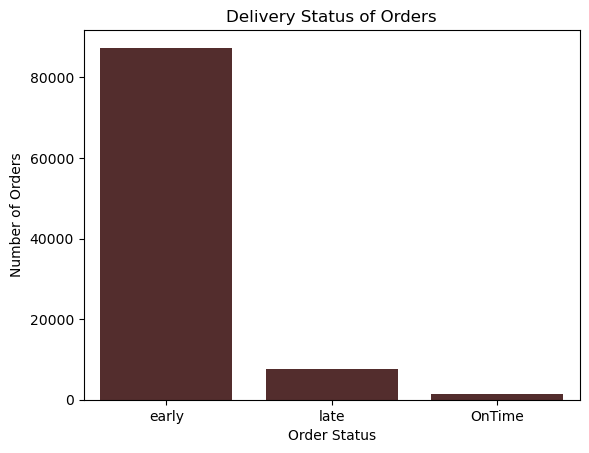

In [37]:
sns.countplot(data = data,x='Order_Status',color='maroon',saturation=0.3)
plt.title('Delivery Status of Orders')
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.show()

#### 5.2 Top and Bottom 5 states with highest and lowest average freight

In [38]:
query = """

WITH FreightData AS
( 
    SELECT
    cus.customer_state State,
    avg(oi.freight_value) AverageFreight
    FROM 
    order_items oi INNER JOIN orders o
    ON o.order_id = oi.order_id
    INNER JOIN
    customers cus
    ON cus.customer_id = o.customer_id
    GROUP BY State
)

SELECT * FROM
(
    SELECT
    State,
    AverageFreight,
    'Top 5' AS Category
    FROM FreightData
    ORDER BY AverageFreight DESC
    LIMIT 5
)

UNION ALL

SELECT * FROM
(
    SELECT
    State,
    AverageFreight,
    'Botton 5' AS Category
    FROM FreightData
    ORDER BY AverageFreight
    LIMIT 5
)
ORDER BY AverageFreight DESC
"""

data = pd.read_sql_query(query,conn)
data

,State,AverageFreight,Category
0,RR,42.984423,Top 5
1,PB,42.723804,Top 5
2,RO,41.069712,Top 5
3,AC,40.073370,Top 5
4,PI,39.147970,Top 5
5,DF,21.041355,Botton 5
6,RJ,20.960924,Botton 5
7,MG,20.630167,Botton 5
8,PR,20.531652,Botton 5
9,SP,15.147275,Botton 5


States with Highest Average Freight Value is : RR, PB, RO, AC, PI


States with Lowest Averge Freight Value is : DF, RJ, MG, PR, SP

#### 5.3 Top and Bottom 5 states with highest and lowest average delivery time

In [39]:
query = """

WITH DeliveryData AS
( 
    SELECT
    cus.customer_state State,
    ROUND(AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp))) AvgDeliveryTime
    FROM 
    orders o INNER JOIN customers cus
    ON cus.customer_id = o.customer_id
    GROUP BY State
)

SELECT * FROM
(
    SELECT
    State,
    AvgDeliveryTime,
    'Top 5' AS Category
    FROM DeliveryData
    WHERE AvgDeliveryTime IS NOT NULL
    ORDER BY AvgDeliveryTime 
    LIMIT 5
)

UNION ALL

SELECT * FROM
(
    SELECT
    State,
    AvgDeliveryTime,
    'Bottom 5' AS Category
    FROM DeliveryData
    WHERE AvgDeliveryTime IS NOT NULL
    ORDER BY AvgDeliveryTime DESC
    LIMIT 5
)
ORDER BY AvgDeliveryTime
"""

data = pd.read_sql_query(query,conn)
data

,State,AvgDeliveryTime,Category
0,SP,9.0,Top 5
1,MG,12.0,Top 5
2,PR,12.0,Top 5
3,DF,13.0,Top 5
4,RJ,15.0,Top 5
5,PA,24.0,Bottom 5
6,AL,25.0,Bottom 5
7,AM,26.0,Bottom 5
8,AP,27.0,Bottom 5
9,RR,29.0,Bottom 5


5 States with Slowest Delivery Time - PA, RR, AM, AL, AP

5 states with fastest Delivery Time - MG, PR, DF, SP, RJ

#### 5.4 Top 5 states with order delivery is faster than estimated time

In [40]:
query = """

SELECT
cus.customer_state ,
avg(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_estimated_delivery_date)) DeliveryDifference
FROM
orders o INNER JOIN customers cus
ON o.customer_id = cus.customer_id
GROUP BY cus.customer_state
ORDER BY DeliveryDifference
LIMIT 5

"""

data = pd.read_sql_query(query,conn)
data

,customer_state,DeliveryDifference
0,AC,-20.077007
1,RO,-19.396826
2,AP,-19.059423
3,AM,-18.851817
4,RR,-16.594598


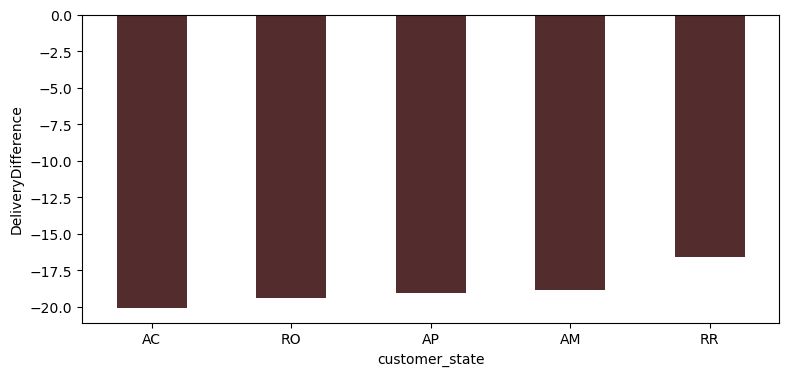

In [41]:
plt.figure(figsize=(9,4))
ax = sns.barplot(data=data,x='customer_state',y='DeliveryDifference',errorbar=None,color='maroon',saturation=0.3,width=0.5)
plt.show()


Top 5 states with the fastest average delivery times are given above. These states have most orders that have been delivered earlier than the estimated time. The values are negative because the delivered dates are before the estimated dates.

#### 6.1 Month Wise count on different payment types

In [42]:
query = """
SELECT 
p.payment_type PaymentType,
STRFTIME('%m',o.order_purchase_timestamp) OrderMonth,
Count(*) OrderCount
FROM
payments p INNER JOIN orders o
ON o.order_id = p.order_id
GROUP BY PaymentType,OrderMonth
"""

data = pd.read_sql_query(query,conn)
data

,PaymentType,OrderMonth,OrderCount
0,UPI,01,1715
1,UPI,02,1723
2,UPI,03,1942
3,UPI,04,1783
4,UPI,05,2035
5,UPI,06,1807
6,UPI,07,2074
7,UPI,08,2077
8,UPI,09,903
9,UPI,10,1056


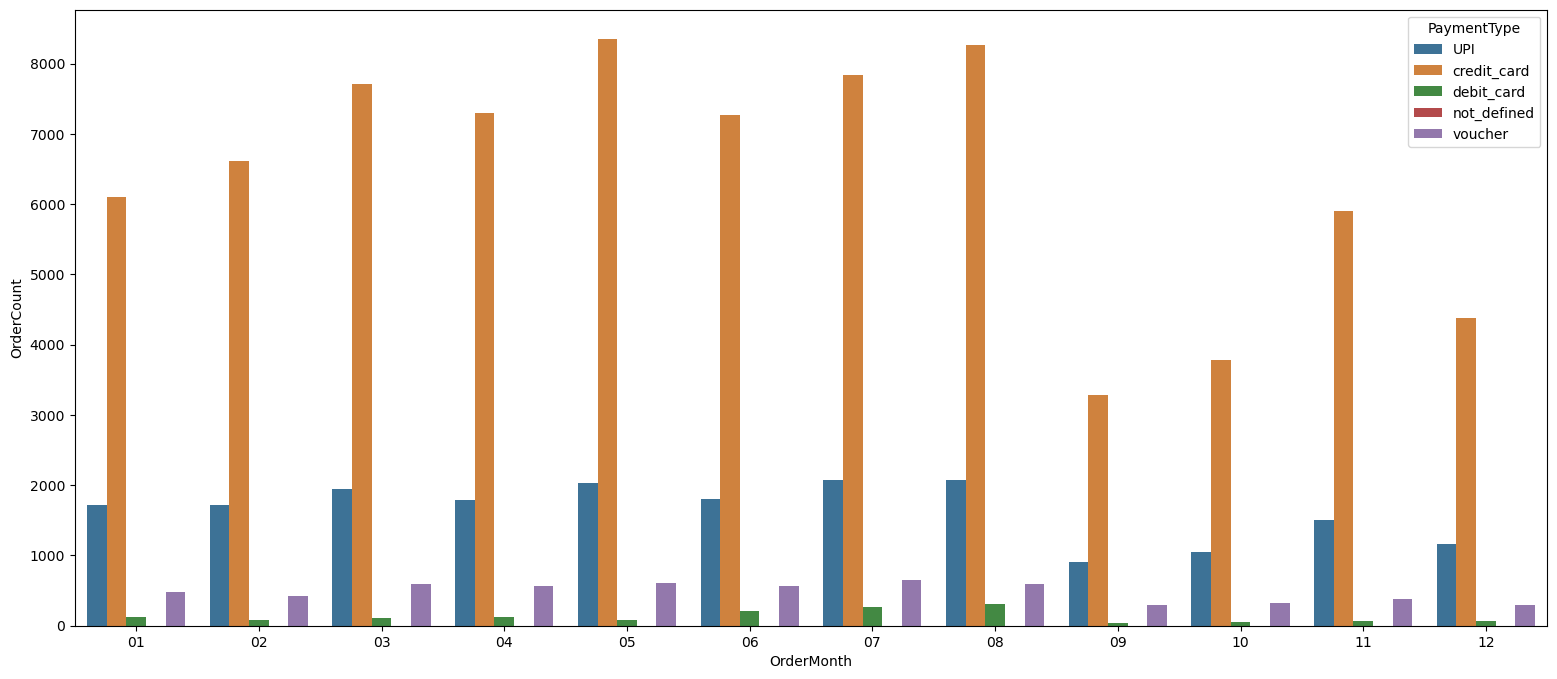

In [43]:
plt.figure(figsize=(19,8))
ax = sns.barplot(data=data,x='OrderMonth',y='OrderCount',hue='PaymentType',saturation=0.6,width=0.8)
plt.show()


The most common form of payment by the customers is credit. Other than credit cards, customers also prefer to use UPI for the payments. There is no specific month in which the customers have a certain preference of payment type.

#### 6.2 Order count for Payment Installments

In [44]:
query = """
SELECT
payment_installments,
count(order_id) 'OrderCount'
FROM
payments
GROUP BY payment_installments
ORDER BY payment_installments


"""
data = pd.read_sql_query(query,conn)
data

,payment_installments,OrderCount
0,0,2
1,1,52546
2,2,12413
3,3,10461
4,4,7098
5,5,5239
6,6,3920
7,7,1626
8,8,4268
9,9,644


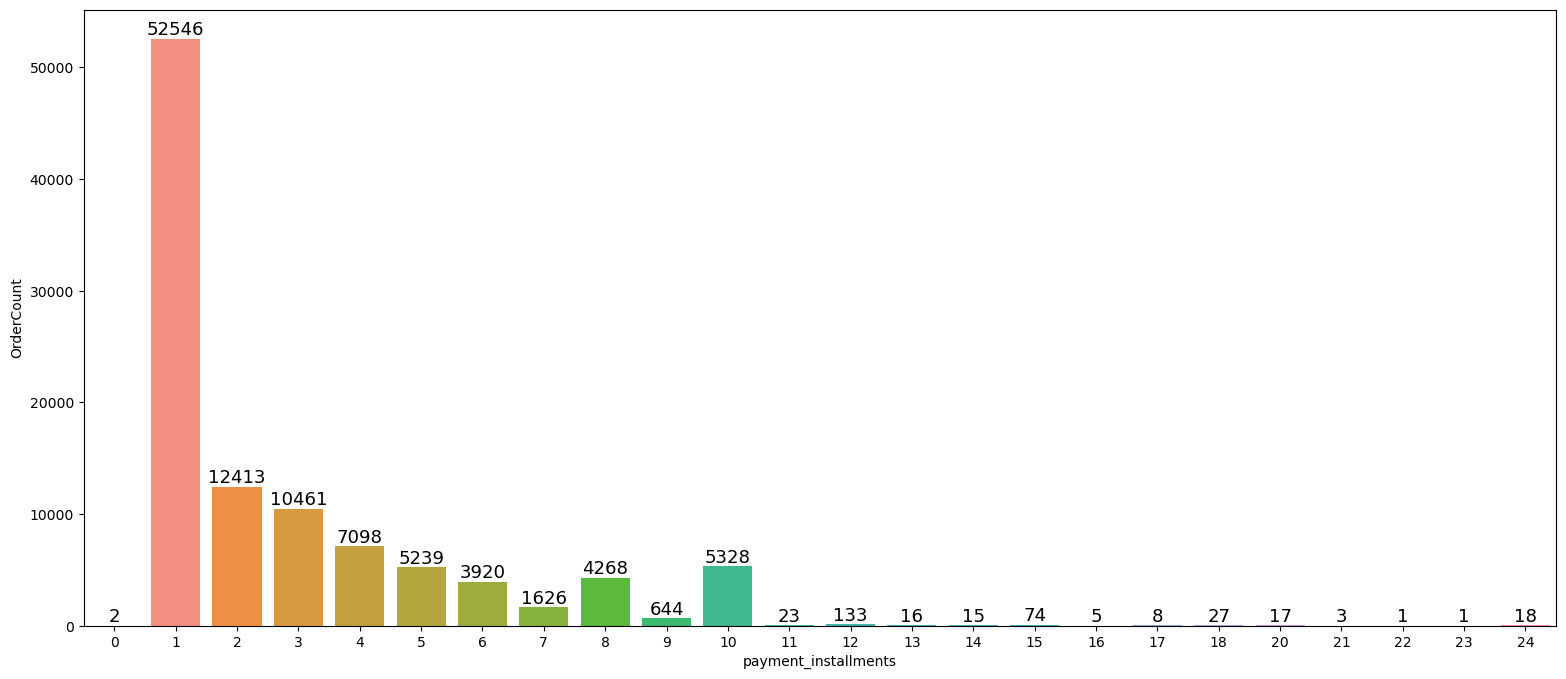

In [45]:
plt.figure(figsize=(19,8))
ax = sns.barplot(data=data,x='payment_installments',y='OrderCount',saturation=0.9,width=0.8)
for label in ax.containers:
    plt.bar_label(label,fontsize=13)
plt.show()


1. Lower installments have higher number of orders. This means that most of the customers prefer to buy less expensive items that require low number of installments.

2. The average price of the orders in this ecommerce site we have seen initially is low. This suggests that most customers buy more economical products.

3. Orders with 1 installment paid is the highest

4. Higher installment are not preferred by most customers. This means that expensive items customers don't prefer to buy using this platform

### Conclusion and Inferences to this Analysis

This project meticulously analyzes various facets of ecommerce customer behavior, including trends in order placement, delivery performance, freight charges, and payment preferences. Here's a synthesized conclusion drawn from the project's findings:

1. **Data Integrity and Range**: Initial analysis confirms the robustness of customer data, characterized by a complete dataset devoid of missing entries. The examination spans orders from September 4, 2016, to October 17, 2018, showcasing a broad geographic footprint across 4119 cities and 27 states.

2. **Trends in Order Volume**: The project identifies a clear upward trend in the volume of orders over the years, suggesting either an increase in the ecommerce platform's popularity or enhanced marketing effectiveness. Additionally, it uncovers a seasonal pattern in purchasing behavior, with a peak in order volumes during the summer months, likely influenced by climatic conditions in Brazil.

3. **Consumer Purchase Timing**: Analysis indicates a pronounced preference among Brazilian customers for shopping in the afternoon, with significant activities also observed in mid-morning and late-night hours. Early morning shopping is notably less popular.

4. **Regional Order Volume Analysis**: The study explores monthly order volumes across different states, uncovering disparities that may reflect regional consumer preferences or differences in logistical efficiency.

5. **Logistics Insights**: The investigation into delivery times versus estimated delivery times sheds light on the states with the most efficient logistics, as well as those with the highest and lowest freight costs. This section also highlights regions where actual delivery times consistently beat estimated times, suggesting either logistical efficiency or conservative estimate practices.

6. **Payment Method Preferences**: Credit payments emerge as the dominant method among consumers, with UPI also gaining traction. An analysis of payment installments demonstrates a consumer tendency towards lower installment payments, indicating a preference for more affordable items or a reflection of the site's lower average order value.

In summary, this project provides an in-depth exploration of the purchasing patterns, delivery logistics, and payment behaviors of ecommerce consumers in Brazil, unveiling critical insights that could steer strategic business decisions and enhance customer engagement strategies.